<a href="https://colab.research.google.com/github/mooniewexx/DL/blob/main/DL_05_4_policy_gradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Policy Gradients

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Саттон Р. С., Барто Э. Дж. Обучение с подкреплением: Введение. 2-е изд.
* Лю Ю. (Х.) Обучение с подкреплением на PyTorch: сборник рецептов / пер. с англ. А. А. Слинкина. – М.: ДМК Пресс, 2020
* https://www.youtube.com/watch?v=_x0ASf9jV9U&ab_channel=sim0nsays
* https://karpathy.github.io/2016/05/31/rl/
* https://neerc.ifmo.ru/wiki/index.php?title=%D0%9C%D0%B5%D1%82%D0%BE%D0%B4%D1%8B_policy_gradient_%D0%B8_%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%B0%D1%81%D0%B8%D0%BD%D1%85%D1%80%D0%BE%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE_%D0%B0%D0%BA%D1%82%D0%BE%D1%80%D0%B0-%D0%BA%D1%80%D0%B8%D1%82%D0%B8%D0%BA%D0%B0
* https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html
* https://huggingface.co/learn/deep-rl-course/unit4/introduction
* https://lilianweng.github.io/posts/2018-04-08-policy-gradient/#:~:text=The%20goal%20of%20reinforcement%20learning,and%20optimizing%20the%20policy%20directly.

In [ ]:
import torch as th
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import Categorical
from tqdm import tqdm
from gymnasium.wrappers import RecordVideo
from IPython.display import HTML
from base64 import b64encode
import os

## Задачи для совместного разбора

1\. Рассмотрите основные шаги по формированию обучающей выборки для использования алгоритмов Policy Gradients.

### Основные шаги по формированию обучающей выборки для Policy Gradients

1. **Сбор данных об эпизодах**:  
   Актёр (агент) взаимодействует с окружением, используя текущую политику, и накапливает траектории в виде последовательностей состояний, действий и наград.

2. **Оценка будущих наград (Returns)**:  
Для каждого временного шага $t$, рассчитать возвращённые награды

 $R_t = \sum_{k=0}^{\infty} \gamma^k r_{t+k}$,

 используя коэффициент дисконтирования $\gamma$.
3. **Вычисление логарифмических вероятностей действий**:  
Для каждого действия, выполненного агентом, вычислить логарифм вероятности

$\log{\pi(a_i | s_i)}$,

используя текущую политику.
4. **Взвешивание логарифмов возвращёнными наградами**:  
Умножить логарифм вероятности действия на соответствующую возвращённую награду $R_t$ для каждого шага.

5. **Обновление параметров политики**:  
С помощью градиентного спуска минимизировать функцию потерь

$L_{\text{PG}} = -\sum_{i} R_i \log \pi(a_i | s_i)$,

чтобы усилить вероятность действий, которые привели к высоким наградам.

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

### 1\. Допишите классы `Policy` для реализации модели политики и `Trainer` для реализации процесса обучения модели при помощи алгоритма REINFORCE. Настройте агента для игры в окружении `CartPole-v1`. Визуализируйте динамику значений награды на эпизод в процессе обучения. Сыграйте эпизод, используя обученного агента, и убедитесь, что агент выучивается, как стабилизировать шест.

$$L_{PG} = -\sum_{i}{R_i\log{p(a_i|s_i)}}$$

$$R_t = \sum_{k=0}^{\infty}\gamma^kr_{t+k}$$

где $r_t$ - награда за шаг $t$.


- [ ] Проверено на семинаре

In [ ]:
@dataclass
class PolicyConfig:
    n_state: int
    n_action: int
    n_hidden: int


class PolicyNetwork(nn.Module):  # сеть политики
    def __init__(self, policy_config: PolicyConfig):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(policy_config.n_state, policy_config.n_hidden),
            nn.ReLU(),
            nn.Linear(policy_config.n_hidden, policy_config.n_action),
            nn.Softmax(dim=-1)
        )

    def forward(self, s: th.Tensor) -> th.Tensor: # проход данных через сеть.

        return self.model(s)

    def get_action(self, s: th.Tensor) -> tuple[int, float]:  # Вычисляеm логарифм вероятности выбранного действия, выбор действия на основе вероятностей
        if not isinstance(s, th.Tensor):
            s = th.tensor(s, dtype=th.float32)

        probs = self.forward(s)
        dist = Categorical(probs)  # распределение над действиями, где каждое действие имеет свою вероятность, полученную от нейронной сети
        action = dist.sample() # выбирает индекс действия пропорционально вероятностям
        log_prob = dist.log_prob(action) # логарифмическая вероятность выбранного действия

        return action.item(), log_prob

 14%|█▍        | 55/400 [00:01<00:10, 32.62it/s]

Episode 50/400, Avg Reward: 24.46


 26%|██▋       | 106/400 [00:03<00:08, 34.27it/s]

Episode 100/400, Avg Reward: 27.24


 38%|███▊      | 153/400 [00:05<00:10, 22.59it/s]

Episode 150/400, Avg Reward: 41.90


 51%|█████     | 204/400 [00:09<00:14, 13.80it/s]

Episode 200/400, Avg Reward: 76.90


 62%|██████▎   | 250/400 [00:16<00:20,  7.47it/s]

Episode 250/400, Avg Reward: 141.60


 75%|███████▍  | 299/400 [00:25<00:23,  4.26it/s]

Episode 300/400, Avg Reward: 189.38


 88%|████████▊ | 350/400 [00:39<00:16,  3.04it/s]

Episode 350/400, Avg Reward: 274.54


100%|██████████| 400/400 [00:47<00:00,  8.38it/s]


Episode 400/400, Avg Reward: 177.96
Total Reward: 125.0


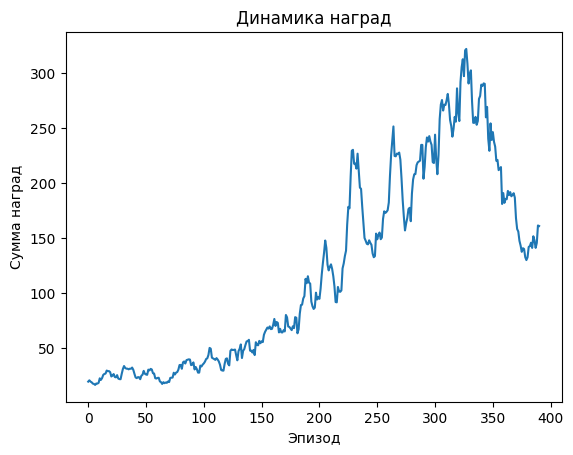

In [ ]:
@dataclass
class TrainConfig:
    gamma: float = 0.99
    learning_rate: float = 0.001
    episode_num: int = 400

class Trainer:
    def __init__(self, policy_config: PolicyConfig, train_config: TrainConfig, env_name="CartPole-v1"):
        self.env = gym.make(env_name, render_mode="rgb_array")
        self.policy = PolicyNetwork(policy_config)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=train_config.learning_rate)
        self.gamma = train_config.gamma
        self.episode_num = train_config.episode_num

    def calculate_discounted_rewards(self, rewards):  # Вычисляем дисконтированные награды: текущая награда уменьшается с учетом времени.

        discounted_rewards = []
        G = 0
        for r in reversed(rewards):
            G = r + self.gamma * G
            discounted_rewards.insert(0, G)
        discounted_rewards = th.tensor(discounted_rewards, dtype=th.float32)
        return (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)

    def train(self):
      '''
              Основной цикл обучения:
        Собираем данные о состоянии, действиях и наградах за эпизод.
        Рассчитываем дисконтированные награды.
        Вычисляем функцию потерь (loss) и обновляем параметры сети.
        Сохраняем награды за эпизоды.
      '''

        episode_rewards = []
        for episode in tqdm(range(self.episode_num)):
            state, _ = self.env.reset()
            state = th.tensor(state, dtype=th.float32)
            log_probs = []
            rewards = []
            done = False

            while not done:
                action, log_prob = self.policy.get_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated

                log_probs.append(log_prob)
                rewards.append(reward)
                state = th.tensor(next_state, dtype=th.float32)

            discounted_rewards = self.calculate_discounted_rewards(rewards)

            loss = 0
            for log_prob, G in zip(log_probs, discounted_rewards):
                loss += -log_prob * G  ##
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            episode_rewards.append(sum(rewards))
            if (episode + 1) % 50 == 0:
                avg_reward = np.mean(episode_rewards[-50:])
                print(f"Episode {episode + 1}/{self.episode_num}, Avg Reward: {avg_reward:.2f}")

        return episode_rewards

    def play(self): ## проверка модели на одной сессии
        state, _ = self.env.reset()
        state = th.tensor(state, dtype=th.float32)
        done = False
        total_reward = 0

        while not done:
            action, _ = self.policy.get_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            total_reward += reward
            state = th.tensor(next_state, dtype=th.float32)
            done = terminated or truncated

        self.env.close()
        print(f"Total Reward: {total_reward}")

# Настройка обучения
policy_config = PolicyConfig(n_state=4, n_action=2, n_hidden=128)
train_config = TrainConfig(gamma=0.99, learning_rate=0.001, episode_num=400)

trainer = Trainer(policy_config, train_config)

# Обучение
episode_rewards = trainer.train()

# Проверка обученного агента
trainer.play()

# Сглаживание и визуализация
def smooth_rewards(rewards, window_size=10):
    return np.convolve(rewards, np.ones(window_size) / window_size, mode='valid')

smoothed_episode_rewards = smooth_rewards(episode_rewards, window_size=10)

plt.plot(smoothed_episode_rewards)
plt.xlabel("Эпизод")
plt.ylabel("Сумма наград")
plt.title("Динамика наград")
plt.show()

# Запись и воспроизведение видео
video_folder = "./video/"
video_env = gym.make('CartPole-v1', render_mode="rgb_array")
video_env = RecordVideo(video_env, video_folder=video_folder, episode_trigger=lambda e: True)

state, _ = video_env.reset()
done = False
while not done:
    action, _ = trainer.policy.get_action(state)
    state, _, terminated, truncated, _ = video_env.step(action)
    done = terminated or truncated
video_env.close()

video_path = f"{video_folder}/rl-video-episode-0.mp4"
def show_video(video_path):
    with open(video_path, 'rb') as video_file:
        video_data = video_file.read()
    video_url = f"data:video/mp4;base64,{b64encode(video_data).decode()}"
    return HTML(f"""<video width="640" height="480" controls>
                      <source src="{video_url}" type="video/mp4">
                    </video>""")
show_video(video_path)

In [ ]:
import base64
from IPython.display import HTML

def encode_video_to_base64(video_path):
    with open(video_path, "rb") as video_file:
        video_base64 = base64.b64encode(video_file.read()).decode('utf-8')
    return video_base64

def display_video_in_notebook(video_path):
    video_base64 = encode_video_to_base64(video_path)
    video_html = f"""
    <video width="640" height="480" controls mute autoplay loop>
        <source src="data:video/mp4;base64,{video_base64}" type="video/mp4">
        Your browser does not support the video tag.
    </video>
    """
    return HTML(video_html)
display_video_in_notebook("Videos/rl-video-episode-0.mp4")

#### Старые решения:

In [ ]:
import torch
import gymnasium as gym
import torch.nn as nn

In [ ]:
from dataclasses import dataclass
@dataclass
class PolicyConfig:
    n_state: int
    n_action: int
    n_hidden: int

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, policy_config: PolicyConfig):
        super().__init__()
        self.cfg = policy_config
        self.model = ...

    def forward(self, s: th.Tensor) -> th.Tensor:
        return self.model(s)

    def get_action(self, s: th.Tensor) -> tuple[int, float]:
        # возвращает действие пропорционально вероятностям, полученным при помощи модели
        # и логарифм вероятности выбранного действия
        pass

In [ ]:
from dataclasses import dataclass

@dataclass
class TrainConfig:
    gamma: float = 0.99
    learning_rate: float = 0.001
    episode_num: float = 400

In [ ]:
import torch as th
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt

@dataclass
class PolicyConfig:
    n_state: int
    n_action: int
    n_hidden: int

@dataclass
class TrainConfig:
    gamma: float = 0.99
    learning_rate: float = 0.001
    episode_num: int = 400

class PolicyNetwork(nn.Module):
    def __init__(self, policy_config: PolicyConfig):
        super().__init__()
        self.cfg = policy_config
        self.model = nn.Sequential(
            nn.Linear(self.cfg.n_state, self.cfg.n_hidden),
            nn.ReLU(),
            nn.Linear(self.cfg.n_hidden, self.cfg.n_action),
            nn.Softmax(dim=-1)
        )

    def forward(self, s: th.Tensor) -> th.Tensor:
        return self.model(s)

    def get_action(self, s: th.Tensor) -> tuple[int, float]:
        if not isinstance(s, th.Tensor):  # Преобразование numpy.ndarray в torch.Tensor
            s = th.tensor(s, dtype=th.float32)

        probs = self.forward(s)
        dist = th.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob

class Trainer:
    def __init__(self, env: gym.Env, policy: PolicyNetwork, config: TrainConfig):
        self.env = env
        self.policy = policy
        self.config = config
        self.optimizer = optim.Adam(self.policy.parameters(), lr=self.config.learning_rate)

    def compute_returns(self, rewards: list[float]) -> list[float]:
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + self.config.gamma * R
            returns.insert(0, R)
        return returns

    def train(self):
        rewards_history = []
        for episode in range(self.config.episode_num):
            state, _ = self.env.reset()
            state = th.tensor(state, dtype=th.float32)


            log_probs = []
            rewards = []

            done = False
            while not done:
                action, log_prob = self.policy.get_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated

                log_probs.append(log_prob)
                rewards.append(reward)
                state = th.tensor(next_state, dtype=th.float32)

            returns = self.compute_returns(rewards)
            returns = th.tensor(returns, dtype=th.float32)

            loss = -th.stack(log_probs) * returns
            loss = loss.sum()

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            rewards_history.append(sum(rewards))
            if (episode + 1) % 50 == 0:
                avg_reward = np.mean(rewards_history[-50:])
                print(f"Episode {episode + 1}/{self.config.episode_num}, Avg Reward: {avg_reward:.2f}")

        return rewards_history


Episode 10/400, Avg Reward: 16.20
Episode 20/400, Avg Reward: 18.40
Episode 30/400, Avg Reward: 16.80
Episode 40/400, Avg Reward: 21.40
Episode 50/400, Avg Reward: 18.00
Episode 60/400, Avg Reward: 19.70
Episode 70/400, Avg Reward: 28.20
Episode 80/400, Avg Reward: 23.40
Episode 90/400, Avg Reward: 25.30
Episode 100/400, Avg Reward: 26.70
Episode 110/400, Avg Reward: 39.30
Episode 120/400, Avg Reward: 31.90
Episode 130/400, Avg Reward: 42.70
Episode 140/400, Avg Reward: 46.40
Episode 150/400, Avg Reward: 61.90
Episode 160/400, Avg Reward: 40.60
Episode 170/400, Avg Reward: 67.40
Episode 180/400, Avg Reward: 49.60
Episode 190/400, Avg Reward: 75.20
Episode 200/400, Avg Reward: 111.80
Episode 210/400, Avg Reward: 126.80
Episode 220/400, Avg Reward: 82.80
Episode 230/400, Avg Reward: 108.30
Episode 240/400, Avg Reward: 166.50
Episode 250/400, Avg Reward: 136.10
Episode 260/400, Avg Reward: 157.90
Episode 270/400, Avg Reward: 171.70
Episode 280/400, Avg Reward: 204.00
Episode 290/400, Avg 

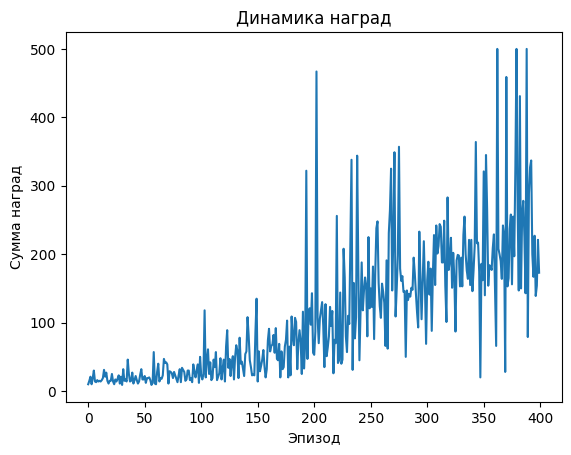

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:250: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [ ]:

# Настройка окружения и параметров
env = gym.make('CartPole-v1', render_mode="human")
policy_config = PolicyConfig(n_state=4, n_action=2, n_hidden=128)
policy = PolicyNetwork(policy_config)

train_config = TrainConfig(episode_num=400)
trainer = Trainer(env, policy, train_config)

# Обучение
rewards = trainer.train()

# Визуализация наград
plt.plot(rewards)
plt.xlabel("Эпизод")
plt.ylabel("Сумма наград")
plt.title("Динамика наград")
plt.show()


# Проверка обученного агента
state, _ = env.reset()
done = False
while not done:
    if not isinstance(state, th.Tensor):  # Преобразование numpy.ndarray в torch.Tensor
        state = th.tensor(state, dtype=th.float32)
    action, _ = policy.get_action(state)
    state, _, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    env.render()
env.close()


In [ ]:

# Настройка окружения и параметров
env = gym.make('CartPole-v1', render_mode="human")
policy_config = PolicyConfig(n_state=4, n_action=2, n_hidden=128)
policy = PolicyNetwork(policy_config)

train_config = TrainConfig(episode_num=400)
trainer = Trainer(env, policy, train_config)

# Обучение
rewards = trainer.train()

# Визуализация наград
plt.plot(rewards)
plt.xlabel("Эпизод")
plt.ylabel("Сумма наград")
plt.title("Динамика наград")
plt.show()


# Проверка обученного агента
state, _ = env.reset()
done = False
while not done:
    if not isinstance(state, th.Tensor):  # Преобразование numpy.ndarray в torch.Tensor
        state = th.tensor(state, dtype=th.float32)
    action, _ = policy.get_action(state)
    state, _, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    env.render()
env.close()


KeyboardInterrupt: 

In [ ]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 10.8 MB/s eta 0:00:00


Episode 50/400, Avg Reward: 21.88
Episode 100/400, Avg Reward: 40.26
Episode 150/400, Avg Reward: 48.10
Episode 200/400, Avg Reward: 85.72
Episode 250/400, Avg Reward: 142.08
Episode 300/400, Avg Reward: 204.78
Episode 350/400, Avg Reward: 226.28
Episode 400/400, Avg Reward: 289.30


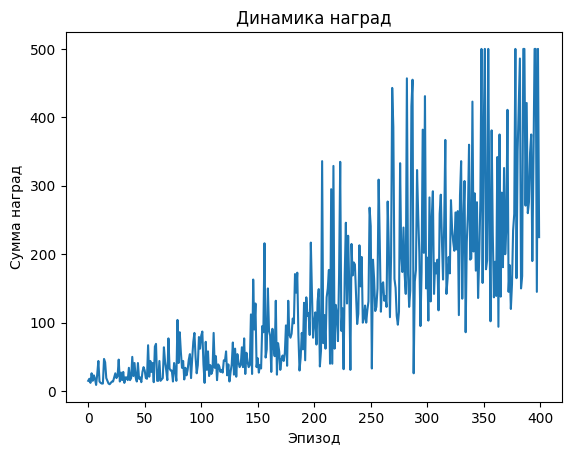

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:250: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


In [ ]:
import torch as th
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt

@dataclass
class PolicyConfig:
    n_state: int
    n_action: int
    n_hidden: int

@dataclass
class TrainConfig:
    gamma: float = 0.99
    learning_rate: float = 0.001
    episode_num: int = 400

class PolicyNetwork(nn.Module):
    def __init__(self, policy_config: PolicyConfig):
        super().__init__()
        self.cfg = policy_config
        self.model = nn.Sequential(
            nn.Linear(self.cfg.n_state, self.cfg.n_hidden),
            nn.ReLU(),
            nn.Linear(self.cfg.n_hidden, self.cfg.n_action),
            nn.Softmax(dim=-1)
        )

    def forward(self, s: th.Tensor) -> th.Tensor:
        return self.model(s)

    def get_action(self, s: th.Tensor) -> tuple[int, float]:
        if not isinstance(s, th.Tensor):  # Преобразование numpy.ndarray в torch.Tensor
            s = th.tensor(s, dtype=th.float32)
        probs = self.forward(s)
        dist = th.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob

class Trainer:
    def __init__(self, env: gym.Env, policy: PolicyNetwork, config: TrainConfig):
        self.env = env
        self.policy = policy
        self.config = config
        self.optimizer = optim.Adam(self.policy.parameters(), lr=self.config.learning_rate)

    def compute_returns(self, rewards: list[float]) -> list[float]:
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + self.config.gamma * R
            returns.insert(0, R)
        return returns

    def train(self):
        rewards_history = []
        for episode in range(self.config.episode_num):
            state, _ = self.env.reset()
            log_probs = []
            rewards = []

            done = False
            while not done:
                action, log_prob = self.policy.get_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated

                log_probs.append(log_prob)
                rewards.append(reward)
                state = next_state

            returns = self.compute_returns(rewards)
            returns = th.tensor(returns, dtype=th.float32)

            loss = -th.stack(log_probs) * returns
            loss = loss.sum()

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            rewards_history.append(sum(rewards))
            if (episode + 1) % 50 == 0:
                avg_reward = np.mean(rewards_history[-50:])
                print(f"Episode {episode + 1}/{self.config.episode_num}, Avg Reward: {avg_reward:.2f}")

        return rewards_history

# Настройка окружения и параметров
env = gym.make('CartPole-v1')
policy_config = PolicyConfig(n_state=4, n_action=2, n_hidden=128)
policy = PolicyNetwork(policy_config)
train_config = TrainConfig(episode_num=400)
trainer = Trainer(env, policy, train_config)

# Обучение
rewards = trainer.train()

# Визуализация наград
plt.plot(rewards)
plt.xlabel("Эпизод")
plt.ylabel("Сумма наград")
plt.title("Динамика наград")
plt.show()

# Проверка обученного агента
state, _ = env.reset()
done = False
while not done:
    action, _ = policy.get_action(state)
    state, _, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    env.render()
env.close()


In [ ]:
import os
from gymnasium.wrappers import RecordVideo
from IPython.display import HTML
from base64 import b64encode

# Функция для отображения видео
def show_video(video_path):
    with open(video_path, 'rb') as video_file:
        video_data = video_file.read()
    video_url = f"data:video/mp4;base64,{b64encode(video_data).decode()}"
    return HTML(f"""<video width="640" height="480" controls>
                      <source src="{video_url}" type="video/mp4">
                    </video>""")

# Настройка окружения для записи видео
video_folder = "./video/"
env = gym.make('CartPole-v1', render_mode="rgb_array")
env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda e: True)

# Обучение агента
policy_config = PolicyConfig(n_state=4, n_action=2, n_hidden=128)
policy = PolicyNetwork(policy_config)
train_config = TrainConfig(episode_num=1000)
trainer = Trainer(env, policy, train_config)

# Тренировка
rewards = trainer.train()

# Воспроизведение обученного агента
state, _ = env.reset()
done = False
while not done:
    action, _ = policy.get_action(state)
    state, _, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
env.close()

# Загрузка видео в Google Drive
from google.colab import drive
drive.mount('/content/drive')
os.system(f"cp {video_folder}/*.mp4 /content/drive/MyDrive/")

# Воспроизведение видео
video_path = f"{video_folder}/rl-video-episode-0.mp4"
show_video(video_path)


Episode 50/1000, Avg Reward: 29.58
Episode 100/1000, Avg Reward: 42.18
Episode 150/1000, Avg Reward: 49.78
Episode 200/1000, Avg Reward: 80.24
Episode 250/1000, Avg Reward: 96.48
Episode 300/1000, Avg Reward: 195.14
Episode 350/1000, Avg Reward: 271.68
Episode 400/1000, Avg Reward: 342.96
Episode 450/1000, Avg Reward: 405.18
Episode 500/1000, Avg Reward: 413.20
Episode 550/1000, Avg Reward: 452.32
Episode 600/1000, Avg Reward: 398.36
Episode 650/1000, Avg Reward: 404.08
Episode 700/1000, Avg Reward: 444.18
Episode 750/1000, Avg Reward: 349.76
Episode 800/1000, Avg Reward: 337.08
Episode 850/1000, Avg Reward: 452.24
Episode 900/1000, Avg Reward: 453.06
Episode 950/1000, Avg Reward: 486.86
Episode 1000/1000, Avg Reward: 454.74
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 14.7 MB/s eta 0:00:00


 14%|█▍        | 55/400 [00:02<00:14, 24.63it/s]

Episode 50/400, Avg Reward: 20.16


 26%|██▌       | 102/400 [00:04<00:19, 15.04it/s]

Episode 100/400, Avg Reward: 50.88


 38%|███▊      | 150/400 [00:11<00:46,  5.43it/s]

Episode 150/400, Avg Reward: 148.56


 50%|█████     | 200/400 [00:21<00:59,  3.38it/s]

Episode 200/400, Avg Reward: 202.06


 62%|██████▎   | 250/400 [00:36<00:46,  3.25it/s]

Episode 250/400, Avg Reward: 313.30


 75%|███████▌  | 301/400 [00:53<00:37,  2.61it/s]

Episode 300/400, Avg Reward: 354.50


 88%|████████▊ | 350/400 [01:07<00:13,  3.81it/s]

Episode 350/400, Avg Reward: 291.96


100%|██████████| 400/400 [01:27<00:00,  4.55it/s]

Episode 400/400, Avg Reward: 420.22


Total Reward: 276.0


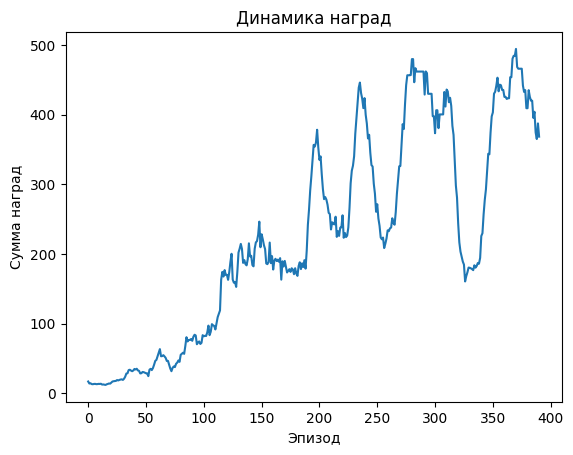

In [ ]:
import torch as th
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import Categorical
from tqdm import tqdm


@dataclass
class PolicyConfig:
    n_state: int
    n_action: int
    n_hidden: int


@dataclass
class TrainConfig:
    gamma: float = 0.99
    learning_rate: float = 0.001
    episode_num: int = 400


class PolicyNetwork(nn.Module):
    def __init__(self, policy_config: PolicyConfig):
        super().__init__()
        self.cfg = policy_config
        self.model = nn.Sequential(
            nn.Linear(self.cfg.n_state, self.cfg.n_hidden),
            nn.ReLU(),
            nn.Linear(self.cfg.n_hidden, self.cfg.n_action),
            nn.Softmax(dim=-1)
        )

    def forward(self, s: th.Tensor) -> th.Tensor:
        return self.model(s)

    def get_action(self, s: th.Tensor) -> tuple[int, float]:
        if not isinstance(s, th.Tensor):  # Преобразование numpy.ndarray в torch.Tensor
            s = th.tensor(s, dtype=th.float32)
        probs = self.forward(s)
        dist = Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob


class Trainer:
    def __init__(self, env_name: str, policy_config: PolicyConfig, train_config: TrainConfig):
        self.env = gym.make(env_name, render_mode="rgb_array")
        self.policy = PolicyNetwork(policy_config)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=train_config.learning_rate)
        self.gamma = train_config.gamma
        self.episode_num = train_config.episode_num

    def calculate_discounted_rewards(self, rewards):
        discounted_rewards = []
        G = 0
        for r in reversed(rewards):
            G = r + self.gamma * G
            discounted_rewards.insert(0, G)
        # Нормализация наград
        discounted_rewards = th.tensor(discounted_rewards, dtype=th.float32)
        return (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)

    def train(self):
        episode_rewards = []
        for episode in tqdm(range(self.episode_num)):
            state, _ = self.env.reset()
            state = th.tensor(state, dtype=th.float32)
            log_probs = []
            rewards = []

            done = False
            while not done:
                action, log_prob = self.policy.get_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated

                log_probs.append(log_prob)
                rewards.append(reward)
                state = th.tensor(next_state, dtype=th.float32)

            discounted_rewards = self.calculate_discounted_rewards(rewards)

            # Обновление политики
            loss = 0
            for log_prob, G in zip(log_probs, discounted_rewards):
                loss += -log_prob * G
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            episode_rewards.append(sum(rewards))
            if (episode + 1) % 50 == 0:
                avg_reward = np.mean(episode_rewards[-50:])
                print(f"Episode {episode + 1}/{self.episode_num}, Avg Reward: {avg_reward:.2f}")

        return episode_rewards

    def play(self):
        state, _ = self.env.reset()
        state = th.tensor(state, dtype=th.float32)
        done = False
        total_reward = 0

        while not done:
            action, _ = self.policy.get_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            total_reward += reward
            state = th.tensor(next_state, dtype=th.float32)
            done = terminated or truncated

        self.env.close()
        print(f"Total Reward: {total_reward}")


# Настройка обучения
env_name = "CartPole-v1"
policy_config = PolicyConfig(n_state=4, n_action=2, n_hidden=512)  # Увеличение скрытых слоев
train_config = TrainConfig(gamma=0.99, learning_rate=0.001, episode_num=400)

trainer = Trainer(env_name=env_name, policy_config=policy_config, train_config=train_config)

# Обучение
episode_rewards = trainer.train()

# Проверка обученного агента
trainer.play()

# Сглаживание и визуализация
def smooth_rewards(rewards, window_size=10):
    smoothed_rewards = np.convolve(rewards, np.ones(window_size) / window_size, mode='valid')
    return smoothed_rewards

smoothed_episode_rewards = smooth_rewards(episode_rewards, window_size=10)

plt.plot(smoothed_episode_rewards)
plt.xlabel("Эпизод")
plt.ylabel("Сумма наград")
plt.title("Динамика наград")
plt.show()

In [ ]:
import os
from gymnasium.wrappers import RecordVideo
from IPython.display import HTML
from base64 import b64encode

# Функция для отображения видео
def show_video(video_path):
    with open(video_path, 'rb') as video_file:
        video_data = video_file.read()
    video_url = f"data:video/mp4;base64,{b64encode(video_data).decode()}"
    return HTML(f"""<video width="640" height="480" controls>
                      <source src="{video_url}" type="video/mp4">
                    </video>""")

# Настройка окружения для записи видео
video_folder = "./video/"
env = gym.make('CartPole-v1', render_mode="rgb_array")
env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda e: True)

# Обучение агента
policy_config = PolicyConfig(n_state=4, n_action=2, n_hidden=128)
policy = PolicyNetwork(policy_config)
train_config = TrainConfig(episode_num=1000)
trainer = Trainer(env, policy, train_config)

# Тренировка
rewards = trainer.train()

# Воспроизведение обученного агента
state, _ = env.reset()
done = False
while not done:
    action, _ = policy.get_action(state)
    state, _, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
env.close()

# Загрузка видео в Google Drive
from google.colab import drive
drive.mount('/content/drive')
os.system(f"cp {video_folder}/*.mp4 /content/drive/MyDrive/")

# Воспроизведение видео
video_path = f"{video_folder}/rl-video-episode-0.mp4"
show_video(video_path)

AssertionError: 

<p class="task" id="2"></p>

### 2\. Повторите решение задачи 1, делая шаг обучения не после одного эпизода, а по результату прогонов нескольких эпизодов. Обратите внимание, что после обновления весов модели все старые данные для обучения становятся неактуальными и должны быть удалены.

- [ ] Проверено на семинаре

In [ ]:
@dataclass
class PolicyConfig:
    n_state: int
    n_action: int
    n_hidden: int

@dataclass
class TrainConfig:
    gamma: float = 0.99
    learning_rate: float = 0.0005
    episode_num: int = 1000
    batch_size: int = 20  # Количество эпизодов в батче

class PolicyNetwork(nn.Module):
    def __init__(self, policy_config: PolicyConfig):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(policy_config.n_state, policy_config.n_hidden),
            nn.ReLU(),
            nn.Linear(policy_config.n_hidden, policy_config.n_action),
            nn.Softmax(dim=-1)
        )

    def forward(self, s: th.Tensor) -> th.Tensor:
        return self.model(s)

    def get_action(self, s: th.Tensor) -> tuple[int, float]:
        if not isinstance(s, th.Tensor):
            s = th.tensor(s, dtype=th.float32)
        probs = self.forward(s)
        dist = Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob

class Trainer:
    def __init__(self, policy_config: PolicyConfig, train_config: TrainConfig, env_name="CartPole-v1"):
        self.env = gym.make(env_name, render_mode="rgb_array", max_episode_steps=1000)
        self.policy = PolicyNetwork(policy_config)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=train_config.learning_rate)
        self.gamma = train_config.gamma
        self.episode_num = train_config.episode_num
        self.batch_size = train_config.batch_size

    def calculate_discounted_rewards(self, rewards):
        discounted_rewards = []
        G = 0
        for r in reversed(rewards):
            G = r + self.gamma * G
            discounted_rewards.insert(0, G)
        discounted_rewards = th.tensor(discounted_rewards, dtype=th.float32)
        return (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)

    def train(self):
        episode_rewards = []
        log_probs_batch = [] # Накопление логарифмов вероятностей и наград для батча
        rewards_batch = []

        for episode in tqdm(range(self.episode_num)):
            state, _ = self.env.reset()
            state = th.tensor(state, dtype=th.float32)
            log_probs = []
            rewards = []
            done = False

            while not done:
                action, log_prob = self.policy.get_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated

                log_probs.append(log_prob)
                rewards.append(reward)
                state = th.tensor(next_state, dtype=th.float32)

            log_probs_batch.extend(log_probs)
            rewards_batch.extend(self.calculate_discounted_rewards(rewards))
            episode_rewards.append(sum(rewards))

            # Обновление после каждых batch_size эпизодов
            if (episode + 1) % self.batch_size == 0:  # модель обновляется каждые batch_size эпизодов
                loss = 0
                for log_prob, G in zip(log_probs_batch, rewards_batch):
                    loss += -log_prob * G
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                log_probs_batch = []  # Сброс накопленных данных
                rewards_batch = []

            if (episode + 1) % 500 == 0:
                avg_reward = np.mean(episode_rewards[-500:])
                print(f"Episode {episode + 1}/{self.episode_num}, Avg Reward: {avg_reward:.2f}")

        return episode_rewards

    def play(self):
        state, _ = self.env.reset()
        state = th.tensor(state, dtype=th.float32)
        done = False
        total_reward = 0

        while not done:
            action, _ = self.policy.get_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            total_reward += reward
            state = th.tensor(next_state, dtype=th.float32)
            done = terminated or truncated

        self.env.close()
        print(f"Total Reward: {total_reward}")

# Настройка обучения
policy_config = PolicyConfig(n_state=4, n_action=2, n_hidden=128)
train_config = TrainConfig(gamma=0.99, learning_rate=0.001, episode_num=10_000, batch_size=20)

trainer = Trainer(policy_config, train_config)

# Обучение
episode_rewards = trainer.train()

# Проверка обученного агента
trainer.play()

# Сглаживание и визуализация
def smooth_rewards(rewards, window_size=10):
    return np.convolve(rewards, np.ones(window_size) / window_size, mode='valid')

smoothed_episode_rewards = smooth_rewards(episode_rewards, window_size=10)

plt.plot(smoothed_episode_rewards)
plt.xlabel("Эпизод")
plt.ylabel("Сумма наград")
plt.title("Динамика наград")
plt.show()

# Запись и воспроизведение видео
video_folder = "./video/"
video_env = gym.make('CartPole-v1', render_mode="rgb_array")
video_env = RecordVideo(video_env, video_folder=video_folder, episode_trigger=lambda e: True)

for _ in range(10):  # Записываем 5 эпизодов подряд
    state, _ = video_env.reset()
    done = False
    while not done:
        action, _ = policy.get_action(state)
        state, _, terminated, truncated, _ = video_env.step(action)
        done = terminated or truncated

video_env.close()

video_path = f"{video_folder}/rl-video-episode-0.mp4"
def show_video(video_path):
    with open(video_path, 'rb') as video_file:
        video_data = video_file.read()
    video_url = f"data:video/mp4;base64,{b64encode(video_data).decode()}"
    return HTML(f"""<video width="640" height="480" controls>
                      <source src="{video_url}" type="video/mp4">
                    </video>""")
show_video(video_path)


  5%|▌         | 507/10000 [00:15<05:02, 31.43it/s]

Episode 500/10000, Avg Reward: 26.63


 10%|█         | 1005/10000 [00:40<08:42, 17.22it/s]

Episode 1000/10000, Avg Reward: 41.77


 15%|█▌        | 1501/10000 [01:16<16:51,  8.41it/s]

Episode 1500/10000, Avg Reward: 63.48


 20%|██        | 2001/10000 [02:25<41:11,  3.24it/s]

Episode 2000/10000, Avg Reward: 120.06


 25%|██▌       | 2501/10000 [04:10<53:59,  2.31it/s]  

Episode 2500/10000, Avg Reward: 180.35


 30%|███       | 3000/10000 [06:48<2:47:13,  1.43s/it]

Episode 3000/10000, Avg Reward: 272.10


 31%|███       | 3056/10000 [07:07<16:12,  7.14it/s]


KeyboardInterrupt: 

Total Reward: 365.0


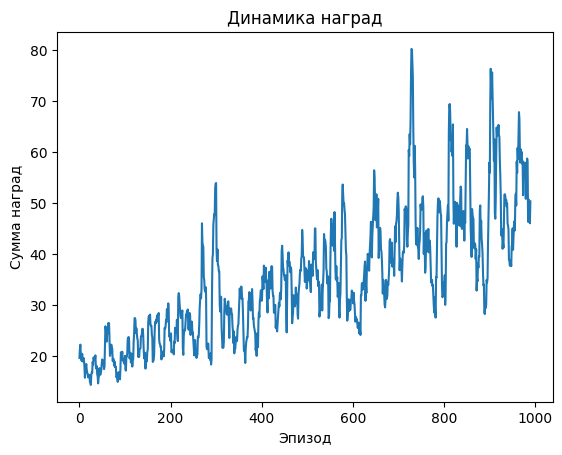

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/rendering.py:416: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


In [ ]:
trainer.play()

# Сглаживание и визуализация
def smooth_rewards(rewards, window_size=10):
    return np.convolve(rewards, np.ones(window_size) / window_size, mode='valid')

smoothed_episode_rewards = smooth_rewards(episode_rewards, window_size=10)

plt.plot(smoothed_episode_rewards)
plt.xlabel("Эпизод")
plt.ylabel("Сумма наград")
plt.title("Динамика наград")
plt.show()

# Запись и воспроизведение видео
video_folder = "./video/"
video_env = gym.make('CartPole-v1', render_mode="rgb_array")
video_env = RecordVideo(video_env, video_folder=video_folder, episode_trigger=lambda e: True)

for _ in range(10):  # Записываем 5 эпизодов подряд
    state, _ = video_env.reset()
    done = False
    while not done:
        action, _ = trainer.policy.get_action(state)
        state, _, terminated, truncated, _ = video_env.step(action)
        done = terminated or truncated

video_env.close()

video_path = f"{video_folder}/rl-video-episode-0.mp4"
def show_video(video_path):
    with open(video_path, 'rb') as video_file:
        video_data = video_file.read()
    video_url = f"data:video/mp4;base64,{b64encode(video_data).decode()}"
    return HTML(f"""<video width="640" height="480" controls>
                      <source src="{video_url}" type="video/mp4">
                    </video>""")
show_video(video_path)


#### Старые решения:

Episode 50/400, Avg Reward: 60.20
Episode 100/400, Avg Reward: 65.12
Episode 150/400, Avg Reward: 64.08
Episode 200/400, Avg Reward: 73.68
Episode 250/400, Avg Reward: 75.60
Episode 300/400, Avg Reward: 70.52
Episode 350/400, Avg Reward: 87.70
Episode 400/400, Avg Reward: 96.06


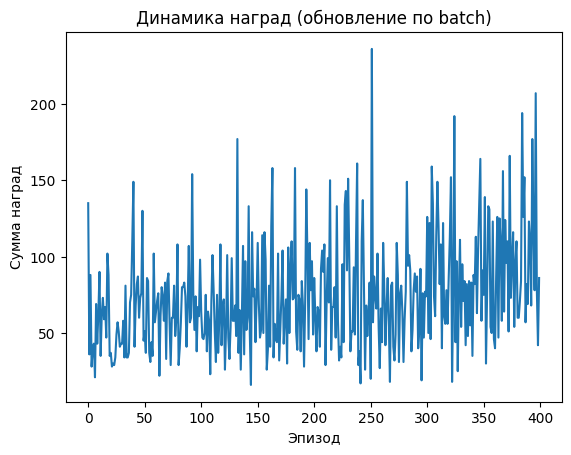

In [ ]:
class TrainerBatch:
    def __init__(self, env: gym.Env, policy: PolicyNetwork, config: TrainConfig, batch_size: int = 10):
        self.env = env
        self.policy = policy
        self.config = config
        self.batch_size = batch_size
        self.optimizer = optim.Adam(self.policy.parameters(), lr=self.config.learning_rate)

    def compute_returns(self, rewards: list[float]) -> list[float]:
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + self.config.gamma * R
            returns.insert(0, R)
        return returns

    def train(self):
        rewards_history = []
        log_probs_batch = []
        returns_batch = []
        total_rewards = []

        for episode in range(self.config.episode_num):
            state, _ = self.env.reset()
            log_probs = []
            rewards = []

            done = False
            while not done:
                action, log_prob = self.policy.get_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated

                log_probs.append(log_prob)
                rewards.append(reward)
                state = next_state

            returns = self.compute_returns(rewards)
            log_probs_batch.extend(log_probs)
            returns_batch.extend(returns)
            total_rewards.append(sum(rewards))

            # Обновляем модель после нескольких эпизодов
            if (episode + 1) % self.batch_size == 0:
                log_probs_batch = th.stack(log_probs_batch)
                returns_batch = th.tensor(returns_batch, dtype=th.float32)

                loss = -log_probs_batch * returns_batch
                loss = loss.sum()

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # Очистка буфера
                log_probs_batch = []
                returns_batch = []

            rewards_history.append(sum(rewards))
            if (episode + 1) % 50 == 0:
                avg_reward = np.mean(rewards_history[-50:])
                print(f"Episode {episode + 1}/{self.config.episode_num}, Avg Reward: {avg_reward:.2f}")

        return rewards_history

# Настройка окружения и параметров
trainer_batch = TrainerBatch(env, policy, train_config, batch_size=10)
rewards_batch = trainer_batch.train()

plt.plot(rewards_batch)
plt.xlabel("Эпизод")
plt.ylabel("Сумма наград")
plt.title("Динамика наград (обновление по batch)")
plt.show()


In [ ]:
# Настройка окружения для записи видео
video_folder = "./video_batch/"
env = gym.make('CartPole-v1', render_mode="rgb_array")
env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda e: e == 0)  # Запись первого эпизода


# Воспроизведение обученного агента
state, _ = env.reset()
done = False
while not done:
    action, _ = policy.get_action(state)
    state, _, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
env.close()

# Загрузка видео в Google Drive
os.system(f"cp {video_folder}/*.mp4 /content/drive/MyDrive/")

# Воспроизведение видео
video_path = f"{video_folder}/rl-video-episode-0.mp4"
show_video(video_path)


In [ ]:
import torch as th
import gymnasium as gym
import torch.nn as nn
import torch.optim as optim
import numpy as np
from dataclasses import dataclass

@dataclass
class PolicyConfig:
    n_state: int
    n_action: int
    n_hidden: int

class PolicyNetwork(nn.Module):
    def __init__(self, policy_config: PolicyConfig):
        super().__init__()
        self.cfg = policy_config
        self.model = nn.Sequential(
            nn.Linear(self.cfg.n_state, self.cfg.n_hidden),
            nn.ReLU(),
            nn.Linear(self.cfg.n_hidden, self.cfg.n_action),
            nn.Softmax(dim=-1)
        )

    def forward(self, s: th.Tensor) -> th.Tensor:
        return self.model(s)

    def get_action(self, s: th.Tensor) -> tuple[int, float]:
        if not isinstance(s, th.Tensor):  # Преобразование numpy.ndarray в torch.Tensor
            s = th.tensor(s, dtype=th.float32)
        probs = self.forward(s)
        dist = th.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob

@dataclass
class TrainConfig:
    gamma: float = 0.99
    learning_rate: float = 0.001
    episode_num: int = 400
    batch_size: int = 10  # Количество эпизодов перед обновлением модели

class Trainer:
    def __init__(self, env, train_config: TrainConfig, policy: PolicyNetwork):
        self.env = env
        self.train_config = train_config
        self.policy = policy
        self.optimizer = optim.Adam(self.policy.parameters(), lr=self.train_config.learning_rate)

    def train(self):
        for episode in range(self.train_config.episode_num):
            states, actions, rewards, log_probs = [], [], [], []
            total_reward = 0

            # Сбор данных по эпизодам
            state, _ = self.env.reset()
            done = False
            while not done:
                action, log_prob = self.policy.get_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                states.append(state)
                actions.append(action)
                rewards.append(reward)
                log_probs.append(log_prob)
                state = next_state
                total_reward += reward
                done = terminated or truncated

            # Вычисление кумулятивной награды с учетом дисконта
            discounted_rewards = []
            cumulative_reward = 0
            for r in reversed(rewards):
                cumulative_reward = r + self.train_config.gamma * cumulative_reward
                discounted_rewards.insert(0, cumulative_reward)

            # Обновление модели по данным нескольких эпизодов
            discounted_rewards = th.tensor(discounted_rewards, dtype=th.float32)
            log_probs = th.stack(log_probs)

            # Потери REINFORCE
            loss = -th.sum(log_probs * discounted_rewards)

            # Оптимизация
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Вывод статистики после каждого batch_size эпизодов
            if (episode + 1) % self.train_config.batch_size == 0:
                print(f"Episode {episode+1}/{self.train_config.episode_num}, Total Reward: {total_reward:.2f}")#, Loss: {loss.item():.4f}")

            # Очистка данных для следующего набора эпизодов
            states = []
            actions = []
            rewards = []
            log_probs = []

# Создание окружения и модели
env = gym.make('CartPole-v1', render_mode="human")
policy_config = PolicyConfig(n_state=4, n_action=2, n_hidden=128)
policy = PolicyNetwork(policy_config)
train_config = TrainConfig(episode_num=500, batch_size=10)
trainer = Trainer(env, train_config, policy)

# Запуск обучения
trainer.train()

Episode 10/500, Total Reward: 29.00
Episode 20/500, Total Reward: 19.00
Episode 30/500, Total Reward: 24.00
Episode 40/500, Total Reward: 26.00
Episode 50/500, Total Reward: 49.00
Episode 60/500, Total Reward: 13.00
Episode 70/500, Total Reward: 21.00
Episode 80/500, Total Reward: 38.00
Episode 90/500, Total Reward: 21.00
Episode 100/500, Total Reward: 44.00
Episode 110/500, Total Reward: 42.00
Episode 120/500, Total Reward: 28.00
Episode 130/500, Total Reward: 66.00
Episode 140/500, Total Reward: 51.00
Episode 150/500, Total Reward: 68.00
Episode 160/500, Total Reward: 18.00
Episode 170/500, Total Reward: 177.00
Episode 180/500, Total Reward: 27.00
Episode 190/500, Total Reward: 105.00
Episode 200/500, Total Reward: 115.00
Episode 210/500, Total Reward: 162.00
Episode 220/500, Total Reward: 236.00
Episode 230/500, Total Reward: 157.00
Episode 240/500, Total Reward: 109.00
Episode 250/500, Total Reward: 275.00
Episode 260/500, Total Reward: 65.00
Episode 270/500, Total Reward: 205.00
E

<p class="task" id="3"></p>

### 3\. Повторите решение задачи 1, реализовав алгоритм REINFONCE с baseline.

$$L_{PG} = -\sum_{i}{A_i\log{p(a_i|s_i)}}$$

$$A_i = R_i - V(s_i)$$

$$R_t = \sum_{k=0}^{\infty}\gamma^kr_{t+k}$$

где $r_t$ - награда за шаг $t$.

$p(a_i|s_i)$ и $V(s_i)$ моделируются при помощи двух независимых сетей. Сеть для политики настраивается аналогично задаче 1 и 2 при помощи функции потерь $L_{PG}$. Сеть для оценки базы настраивается в процессе решения задачи регрессии: $L_{V} = \sum_i(V(s_i) - R_i)^2$. Настройка весов обеих моделей происходит после каждого эпизода.

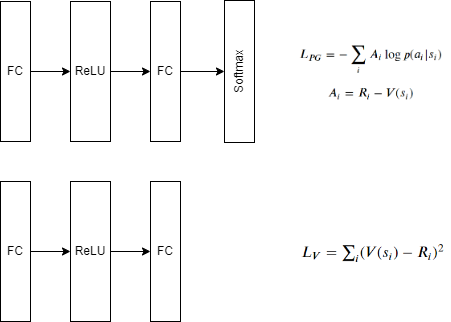

- [ ] Проверено на семинаре

 13%|█▎        | 52/400 [00:02<00:19, 17.46it/s]

Episode 50/400, Avg Reward: 25.30


 25%|██▌       | 101/400 [00:05<00:14, 20.33it/s]

Episode 100/400, Avg Reward: 36.42


 38%|███▊      | 152/400 [00:08<00:17, 14.47it/s]

Episode 150/400, Avg Reward: 54.10


 50%|█████     | 200/400 [00:12<00:17, 11.69it/s]

Episode 200/400, Avg Reward: 65.14


 62%|██████▎   | 250/400 [00:21<00:27,  5.52it/s]

Episode 250/400, Avg Reward: 119.44


 75%|███████▌  | 301/400 [00:33<00:22,  4.37it/s]

Episode 300/400, Avg Reward: 173.70


 88%|████████▊ | 350/400 [00:55<00:38,  1.31it/s]

Episode 350/400, Avg Reward: 309.02


100%|██████████| 400/400 [01:15<00:00,  5.29it/s]

Episode 400/400, Avg Reward: 321.32


Total Reward: 221.0


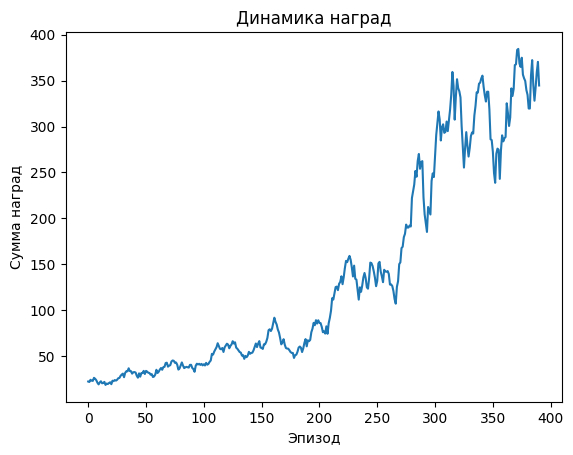

In [ ]:
@dataclass
class PolicyConfig:
    n_state: int
    n_action: int
    n_hidden: int

@dataclass
class TrainConfig:
    gamma: float = 0.99
    learning_rate: float = 0.001
    episode_num: int = 400

class PolicyNetwork(nn.Module):
    def __init__(self, policy_config: PolicyConfig):
        super().__init__()
        self.cfg = policy_config
        self.model = nn.Sequential(
            nn.Linear(self.cfg.n_state, self.cfg.n_hidden),
            nn.ReLU(),
            nn.Linear(self.cfg.n_hidden, self.cfg.n_action),
            nn.Softmax(dim=-1)
        )

    def forward(self, s: th.Tensor) -> th.Tensor:
        return self.model(s)

    def get_action(self, s: th.Tensor) -> tuple[int, float]:
        if not isinstance(s, th.Tensor):
            s = th.tensor(s, dtype=th.float32)
        probs = self.forward(s)
        dist = Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob



class ValueNetwork(nn.Module):  # сеть для оценки состояния V(s), позволяет вычислять baseline
    def __init__(self, policy_config: PolicyConfig):
        super().__init__()
        self.cfg = policy_config
        self.model = nn.Sequential(
            nn.Linear(self.cfg.n_state, self.cfg.n_hidden),
            nn.ReLU(),
            nn.Linear(self.cfg.n_hidden, 1)
        )

    def forward(self, s: th.Tensor) -> th.Tensor:
        return self.model(s).squeeze(-1)



class Trainer:
    def __init__(self, env_name: str, policy_config: PolicyConfig, train_config: TrainConfig):
        self.env = gym.make(env_name, render_mode="rgb_array")
        self.policy = PolicyNetwork(policy_config)
        self.value = ValueNetwork(policy_config)

        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=train_config.learning_rate)
        self.value_optimizer = optim.Adam(self.value.parameters(), lr=train_config.learning_rate)

        self.gamma = train_config.gamma
        self.episode_num = train_config.episode_num

    def calculate_discounted_rewards(self, rewards):
        discounted_rewards = []
        G = 0
        for r in reversed(rewards):
            G = r + self.gamma * G
            discounted_rewards.insert(0, G)
        return th.tensor(discounted_rewards, dtype=th.float32)

    def train(self):
        episode_rewards = []
        for episode in tqdm(range(self.episode_num)):
            state, _ = self.env.reset()
            state = th.tensor(state, dtype=th.float32)
            log_probs = []
            rewards = []
            values = []

            done = False
            while not done:
                action, log_prob = self.policy.get_action(state)
                value = self.value(state)

                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated

                log_probs.append(log_prob)
                rewards.append(reward)
                values.append(value)

                state = th.tensor(next_state, dtype=th.float32)

            discounted_rewards = self.calculate_discounted_rewards(rewards)

            # Advantage Calculation
            values = th.stack(values)
            advantages = discounted_rewards - values.detach()  ###

            # Policy Loss
            policy_loss = -th.sum(th.stack(log_probs) * advantages)

            # Value Loss
            value_loss = th.sum((values - discounted_rewards) ** 2)

            # Optimize Policy Network
            self.policy_optimizer.zero_grad()
            policy_loss.backward()
            self.policy_optimizer.step()

            # Optimize Value Network
            self.value_optimizer.zero_grad()
            value_loss.backward()
            self.value_optimizer.step()

            episode_rewards.append(sum(rewards))
            if (episode + 1) % 50 == 0:
                avg_reward = np.mean(episode_rewards[-50:])
                print(f"Episode {episode + 1}/{self.episode_num}, Avg Reward: {avg_reward:.2f}")

        return episode_rewards

    def play(self):
        state, _ = self.env.reset()
        state = th.tensor(state, dtype=th.float32)
        done = False
        total_reward = 0

        while not done:
            action, _ = self.policy.get_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            total_reward += reward
            state = th.tensor(next_state, dtype=th.float32)
            done = terminated or truncated

        self.env.close()
        print(f"Total Reward: {total_reward}")

# Настройка обучения
env_name = "CartPole-v1"
policy_config = PolicyConfig(n_state=4, n_action=2, n_hidden=128)
train_config = TrainConfig(gamma=0.99, learning_rate=0.001, episode_num=400)

trainer = Trainer(env_name=env_name, policy_config=policy_config, train_config=train_config)

# Обучение
episode_rewards = trainer.train()

# Проверка обученного агента
trainer.play()

# Сглаживание и визуализация
def smooth_rewards(rewards, window_size=10):
    smoothed_rewards = np.convolve(rewards, np.ones(window_size) / window_size, mode='valid')
    return smoothed_rewards

smoothed_episode_rewards = smooth_rewards(episode_rewards, window_size=10)

plt.plot(smoothed_episode_rewards)
plt.xlabel("Эпизод")
plt.ylabel("Сумма наград")
plt.title("Динамика наград")
plt.show()

# Добавление записи видео
import os
from gymnasium.wrappers import RecordVideo
from IPython.display import HTML
from base64 import b64encode

def show_video(video_path):
    with open(video_path, 'rb') as video_file:
        video_data = video_file.read()
    video_url = f"data:video/mp4;base64,{b64encode(video_data).decode()}"
    return HTML(f"""<video width="640" height="480" controls>
                  <source src="{video_url}" type="video/mp4">
                </video>""")

# Настройка окружения для записи видео
video_folder = "./video/"
record_env = gym.make(env_name, render_mode="rgb_array")
record_env = RecordVideo(record_env, video_folder=video_folder, episode_trigger=lambda e: True)

# Воспроизведение агента с записью видео
state, _ = record_env.reset()
done = False
frames = 0
while not done and frames < 150:  # Около 5 секунд видео при 30 FPS
    action, _ = trainer.policy.get_action(th.tensor(state, dtype=th.float32))
    state, _, terminated, truncated, _ = record_env.step(action)
    done = terminated or truncated
    frames += 1
record_env.close()

# Воспроизведение видео
video_path = f"{video_folder}/rl-video-episode-0.mp4"
show_video(video_path)


<p class="task" id="4"></p>

### 4\. Повторите решение задачи 1, реализовав алгоритм Actor-Critic

$$L_{PG} = -\sum_{i}{A_i\log{p(a_i|s_i)}}$$

$$A_i = R_i - V(s_i)$$

$$R_t = \sum_{k=0}^{\infty}\gamma^kr_{t+k}$$

где $r_t$ - награда за шаг $t$.

$p(a_i|s_i)$ и $V(s_i)$ моделируются при помощи одной сети в двумя головами. Голова для политики настраивается аналогично задаче 1 и 2 при помощи функции потерь $L_{PG}$. Голова для оценки базы настраивается в процессе решения задачи регрессии: $L_{V} = \sum_i(V(s_i) - R_i)^2$. Итоговая функции потерь для настройки представляет из себя сумму функций потерь для голов: $L = L_{PG} + L_{V}$.

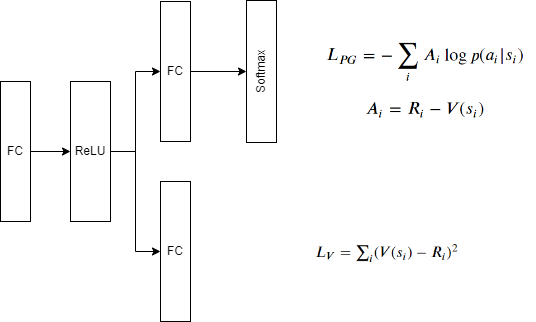

- [ ] Проверено на семинаре

 14%|█▎        | 54/400 [00:01<00:08, 41.77it/s]

Episode 50/400, Avg Reward: 21.24


 26%|██▋       | 106/400 [00:02<00:09, 30.33it/s]

Episode 100/400, Avg Reward: 29.78


 38%|███▊      | 151/400 [00:05<00:18, 13.58it/s]

Episode 150/400, Avg Reward: 45.80


 50%|█████     | 201/400 [00:09<00:14, 13.85it/s]

Episode 200/400, Avg Reward: 67.22


 63%|██████▎   | 252/400 [00:14<00:16,  9.18it/s]

Episode 250/400, Avg Reward: 87.28


 75%|███████▌  | 301/400 [00:22<00:12,  7.83it/s]

Episode 300/400, Avg Reward: 129.10


 88%|████████▊ | 350/400 [00:30<00:19,  2.60it/s]

Episode 350/400, Avg Reward: 138.40


100%|██████████| 400/400 [00:45<00:00,  8.78it/s]

Episode 400/400, Avg Reward: 241.76
Total Reward: 500.0

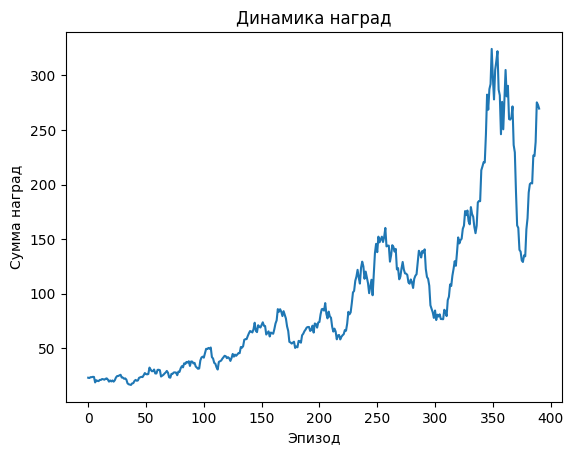

In [ ]:
@dataclass
class Config:
    n_state: int
    n_action: int
    n_hidden: int

    gamma: float = 0.99
    learning_rate: float = 0.001
    episode_num: int = 400

class ActorCriticNetwork(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(config.n_state, config.n_hidden),
            nn.ReLU()
        )
        self.actor = nn.Sequential(
            nn.Linear(config.n_hidden, config.n_action),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Linear(config.n_hidden, 1)

    def forward(self, state):
        shared_out = self.shared(state)
        action_probs = self.actor(shared_out)
        value = self.critic(shared_out)
        return action_probs, value



class ActorCriticTrainer:
    def __init__(self, env_name: str, config: Config):
        self.env = gym.make(env_name, render_mode="rgb_array")
        self.config = config
        self.model = ActorCriticNetwork(config)
        self.optimizer = optim.Adam(self.model.parameters(), lr=config.learning_rate)

    def calculate_discounted_rewards(self, rewards):
        discounted_rewards = []
        G = 0
        for r in reversed(rewards):
            G = r + self.config.gamma * G
            discounted_rewards.insert(0, G)
        return th.tensor(discounted_rewards, dtype=th.float32)

    def train(self):
        episode_rewards = []
        for episode in tqdm(range(self.config.episode_num)):
            state, _ = self.env.reset()
            state = th.tensor(state, dtype=th.float32)

            log_probs = []
            values = []
            rewards = []

            done = False
            while not done:
                action_probs, value = self.model(state)
                dist = Categorical(action_probs)
                action = dist.sample()
                log_prob = dist.log_prob(action)

                next_state, reward, terminated, truncated, _ = self.env.step(action.item())
                done = terminated or truncated

                log_probs.append(log_prob)
                values.append(value)
                rewards.append(reward)

                state = th.tensor(next_state, dtype=th.float32)

            discounted_rewards = self.calculate_discounted_rewards(rewards)
            values = th.cat(values)
            advantages = discounted_rewards - values.squeeze()

            # Compute losses
            actor_loss = -th.stack(log_probs) * advantages.detach()
            critic_loss = advantages.pow(2)
            loss = actor_loss.sum() + critic_loss.sum()

            # Backpropagation
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            episode_rewards.append(sum(rewards))
            if (episode + 1) % 50 == 0:
                avg_reward = np.mean(episode_rewards[-50:])
                print(f"Episode {episode + 1}/{self.config.episode_num}, Avg Reward: {avg_reward:.2f}")

        return episode_rewards

    def play(self):
        state, _ = self.env.reset()
        state = th.tensor(state, dtype=th.float32)
        done = False
        total_reward = 0

        while not done:
            action_probs, _ = self.model(state)
            action = th.argmax(action_probs).item()
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            total_reward += reward
            state = th.tensor(next_state, dtype=th.float32)
            done = terminated or truncated

        self.env.close()
        print(f"Total Reward: {total_reward}")

# Configuration
env_name = "CartPole-v1"
config = Config(n_state=4, n_action=2, n_hidden=128, gamma=0.99, learning_rate=0.001, episode_num=400)

# Training
trainer = ActorCriticTrainer(env_name, config)
episode_rewards = trainer.train()

# Evaluation
trainer.play()

# Visualization
def smooth_rewards(rewards, window_size=10):
    smoothed_rewards = np.convolve(rewards, np.ones(window_size) / window_size, mode='valid')
    return smoothed_rewards

smoothed_episode_rewards = smooth_rewards(episode_rewards, window_size=10)

plt.plot(smoothed_episode_rewards)
plt.xlabel("Эпизод")
plt.ylabel("Сумма наград")
plt.title("Динамика наград")
plt.show()

# Record video
from gymnasium.wrappers import RecordVideo
import os
from base64 import b64encode
from IPython.display import HTML

def show_video(video_path):
    with open(video_path, 'rb') as video_file:
        video_data = video_file.read()
    video_url = f"data:video/mp4;base64,{b64encode(video_data).decode()}"
    return HTML(f"""<video width="640" height="480" controls>
                  <source src="{video_url}" type="video/mp4">
                </video>""")

video_folder = "./video/"
record_env = RecordVideo(gym.make(env_name, render_mode="rgb_array"), video_folder=video_folder, episode_trigger=lambda e: True)
state, _ = record_env.reset()
done = False
while not done:
    state = th.tensor(state, dtype=th.float32)
    action_probs, _ = trainer.model(state)
    action = th.argmax(action_probs).item()
    state, _, terminated, truncated, _ = record_env.step(action)
    done = terminated or truncated
record_env.close()

video_path = os.path.join(video_folder, "rl-video-episode-0.mp4")
show_video(video_path)


## Обратная связь
- [ ] Хочу получить обратную связь по решению